In [2]:
from scipy.sparse import load_npz
import matplotlib.pyplot as plt
import numpy as np
import sklearn.cluster
from collections import defaultdict, namedtuple, Counter
from os import listdir
from itertools import combinations
import json
import scipy.stats as stats

In [17]:
phase_dir = '../phased_spark_quads_del'
with open('%s/chr.10.125500000.126500000.families.json' % phase_dir, 'r') as f:
    families = json.load(f)
ped_file = '../../DATA/spark/spark.ped.quads.ped'
identicals_file = '../sibpair_similarity/spark_quads_identicals.txt'
    
parental_variants = load_npz('%s/chr.10.125500000.126500000.parental_variants.npz' % phase_dir)

In [18]:
has_variant = parental_variants.T.dot(np.ones((parental_variants.shape[0],)))>0
has_variant_indices = has_variant.nonzero()[0] 
var_data = parental_variants[:, has_variant].A
print(var_data.shape)

(632, 260)


In [19]:
families_to_remove = sorted(set([int(np.floor(x/4)) for x in np.where(np.all(var_data==0, axis=1))[0]]))
families = [x for i, x in enumerate(families) if i not in families_to_remove]
indices = np.ones((parental_variants.shape[0],), dtype=bool)
for i in families_to_remove:
    indices[(4*i):(4*(i+1))] = False
var_data = var_data[indices, :]
print(len(families)*4)
print(var_data.shape)

632
(632, 260)


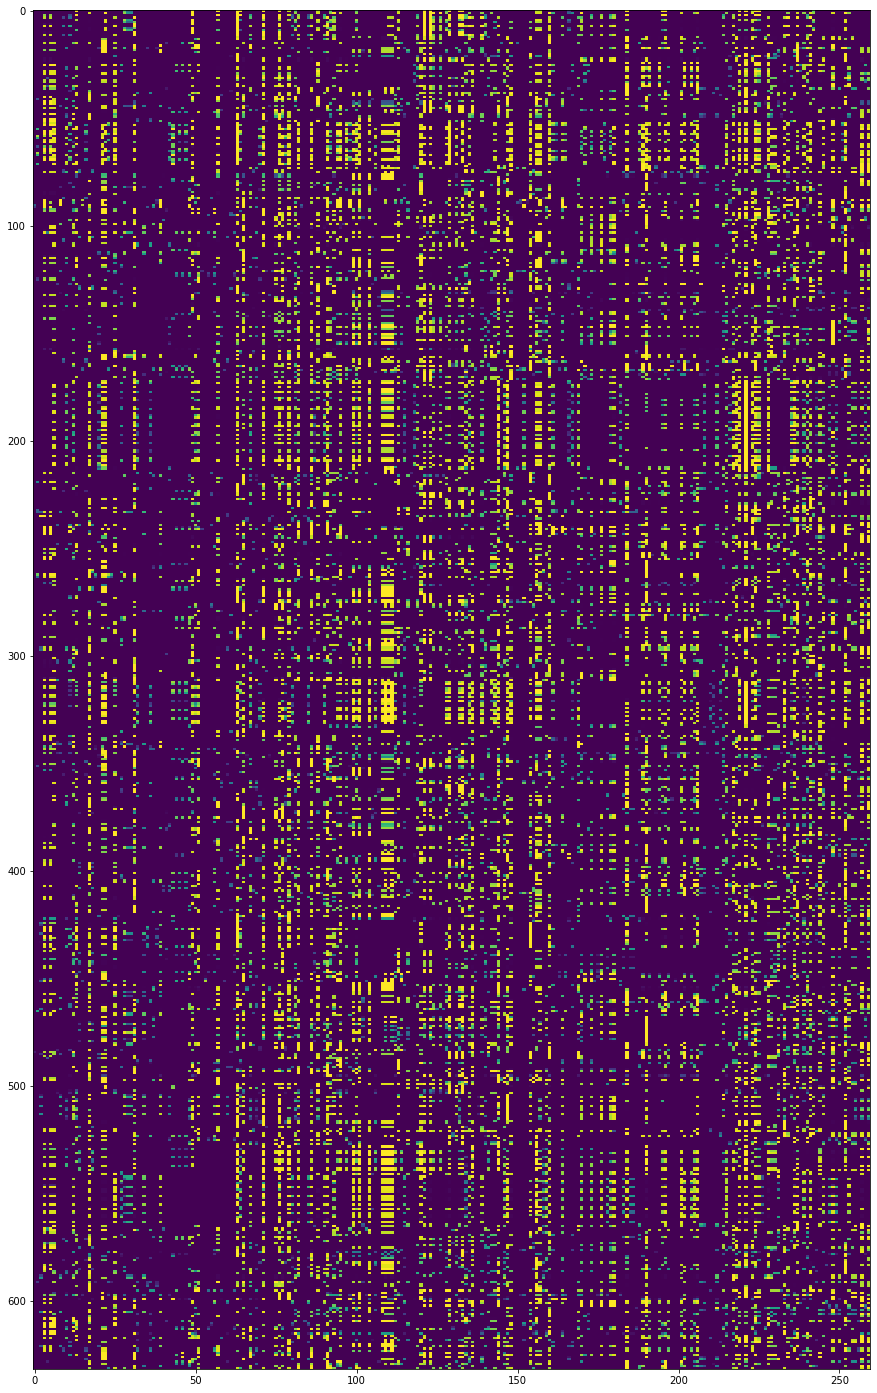

In [20]:
plt.figure(figsize=(15, 25))
plt.imshow(var_data, aspect='auto', vmin=0, vmax=1)
plt.show()

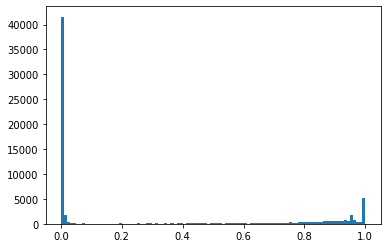

In [21]:
plt.hist(var_data.flatten()[var_data.flatten() != 0], bins=np.arange(0, 1.01, 0.01))
plt.show()

In [22]:
print(np.min(var_data), np.max(var_data))

0.0 0.999999999999949


In [41]:
#clustering = sklearn.cluster.AgglomerativeClustering(affinity='cosine', linkage='complete',
#                                                     n_clusters=2).fit(var_data)

clustering = sklearn.cluster.DBSCAN(metric='cosine', eps=0.6, min_samples=5).fit((var_data>0.9).astype(int))



In [42]:
print(Counter(clustering.labels_))

Counter({0: 630, -1: 2})


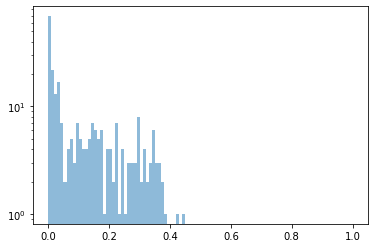

In [43]:
num_clusters = np.max(clustering.labels_)+1
cluster_centroids = np.zeros((num_clusters, var_data.shape[1]))
for i in range(num_clusters):
    cluster_centroids[i, :] = np.mean(var_data[clustering.labels_==i, :], axis=0)
    plt.hist(cluster_centroids[i, :], bins=np.arange(0, 1.01, 0.01), alpha=0.5, log=True)
plt.show()

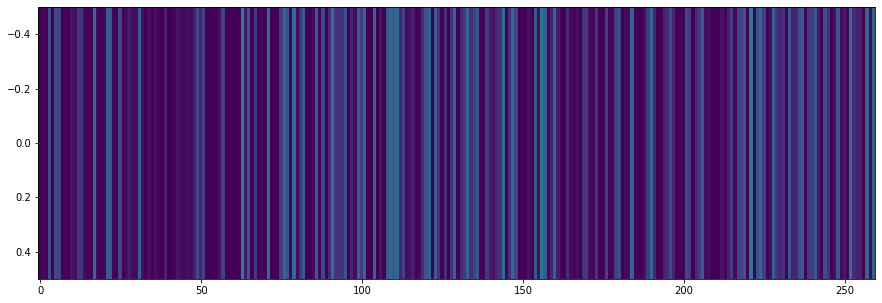

In [44]:
plt.figure(figsize=(15, 5))
plt.imshow(cluster_centroids, aspect='auto', vmin=0, vmax=1)
plt.show()

# Now do haplotype TDT

In [45]:
chrom = '10'
start_interval, end_interval = 125500000, 126500000

In [46]:
def pull_phenotype_ped(ped_file):
	sample_to_sex = dict()
	sample_to_affected = dict()
	with open(ped_file, 'r') as f:
		for line in f:
			pieces = line.strip().split('\t')
			sample_to_sex[pieces[1]] = pieces[4]
			sample_to_affected[pieces[1]] = pieces[5]
	return sample_to_affected, sample_to_sex

sample_to_affected, sample_to_sex = pull_phenotype_ped(ped_file)


In [47]:
# pull identicals
leave_out = set()
with open(identicals_file, 'r') as f:
	for line in f:
		pieces = line.strip().split('\t')
		leave_out.update(pieces[1:])

In [48]:
# pull transmission matrix
# cluster, notrans/trans, unaff/aff, mat/pat
transmission = np.zeros((num_clusters, 2, 2, 2))
for family_index, family in enumerate(families):
    # figure out which cluster the parental haplotypes are in
    haplotypes = clustering.labels_[(4*family_index):(4*(family_index+1))]
    
    # figure out which parental copy is transmitted
    # child1/child2, 0/1/2/3
    trans_data = np.zeros((2, 4), dtype=int)
    print('%s/%s.phased.txt' % (phase_dir, family))
    with open('%s/%s.phased.txt' % (phase_dir, family), 'r')  as f:
        try:
            header = next(f).strip().split('\t')
            individuals = [header[i][:-4] for i in range(5, len(header)-3, 2)]

            if len(individuals)==4:
                for line in f:
                    pieces = line.strip().split('\t')
                    if pieces[0][3:] == chrom:
                        start_pos, end_pos = [int(x) for x in pieces[-2:]]
                        state = np.array([int(x) for x in pieces[1:-2]])

                        sib1_ind_index, sib2_ind_index = 2, 3
                        sib1_mat_index, sib2_mat_index = 4+2*sib1_ind_index, 4+2*sib2_ind_index
                        sib1_pat_index, sib2_pat_index = 5+2*sib1_ind_index, 5+2*sib2_ind_index

                        overlap = min(end_interval, end_pos) - max(start_interval, start_pos)
                        if overlap > 0:
                            if state[sib1_mat_index] != -1:
                                trans_data[0, int(state[sib1_mat_index])] += overlap
                            if state[sib1_pat_index] != -1:
                                trans_data[0, int(state[sib1_pat_index])] += overlap
                            if state[sib2_mat_index] != -1:
                                trans_data[1, int(state[sib2_mat_index])] += overlap
                            if state[sib2_pat_index] != -1:
                                trans_data[1, int(state[sib2_pat_index])] += overlap

                assert np.all(np.sum(trans_data[:, :2], axis=1) <= (end_interval-start_interval))
                assert np.all(np.sum(trans_data[:, 2:], axis=1) <= (end_interval-start_interval))

                # figure out child phenotypes
                aff = [int(sample_to_affected[x]=='2') for x in individuals[2:4]]

                opp_anc_index = {0:1, 1:0, 2:3, 3:2}

                # cluster, notrans/trans, unaff/aff
                for child_index in range(2):
                    if individuals[2+child_index] not in leave_out:
                        for anc_index in range(4):
                            if trans_data[child_index, anc_index] >= 0.9*(end_interval-start_interval):
                                transmission[haplotypes[anc_index], 1, aff[child_index], int(anc_index<2)] += 1
                                transmission[haplotypes[opp_anc_index[anc_index]], 0, aff[child_index], int(anc_index<2)] += 1

                        leave_out.add(individuals[2+child_index])
        except:
            pass
        

../phased_spark_quads_del/SF0000027.SP0000027.SP0000034.phased.txt
../phased_spark_quads_del/SF0000027.SP0000027.SP0000063.phased.txt
../phased_spark_quads_del/SF0000027.SP0000034.SP0000063.phased.txt
../phased_spark_quads_del/SF0000145.SP0001673.SP0000145.phased.txt
../phased_spark_quads_del/SF0000226.SP0000285.SP0000226.phased.txt
../phased_spark_quads_del/SF0000267.SP0001200.SP0000267.phased.txt
../phased_spark_quads_del/SF0000300.SP0000447.SP0000300.phased.txt
../phased_spark_quads_del/SF0000300.SP0000447.SP0000734.phased.txt
../phased_spark_quads_del/SF0000300.SP0000734.SP0000300.phased.txt
../phased_spark_quads_del/SF0000301.SP0000301.SP0000760.phased.txt
../phased_spark_quads_del/SF0000362.SP0000523.SP0000362.phased.txt
../phased_spark_quads_del/SF0000463.SP0000463.SP0000533.phased.txt
../phased_spark_quads_del/SF0000551.SP0001640.SP0000551.phased.txt
../phased_spark_quads_del/SF0000834.SP0000834.SP0001066.phased.txt
../phased_spark_quads_del/SF0000834.SP0000967.SP0000834.phased

In [49]:
for i in range(num_clusters):
    try:
        print(i, 'n=', np.sum(clustering.labels_==i))
        #print('maternal')
        #print(transmission[i, :, :, 0])
        #print('unaff', stats.binom_test(transmission[i, :, 0, 0]))
        #print('aff', stats.binom_test(transmission[i, :, 1, 0]))
        #print('chi2', stats.chi2_contingency(transmission[i, :, :, 0])[1])
        #print('paternal')
        #print(transmission[i, :, :, 1])
        #print('unaff', stats.binom_test(transmission[i, :, 0, 1]))
        #print('aff', stats.binom_test(transmission[i, :, 1, 1]))
        #print('chi2', stats.chi2_contingency(transmission[i, :, :, 1])[1])
        #print('both')
        print(np.sum(transmission[i, :, :, :], axis=2))
        print('unaff', stats.binom_test(np.sum(transmission[i, :, 0, :], axis=1)))
        print('aff', stats.binom_test(np.sum(transmission[i, :, 1, :], axis=1)))
        print('chi2', stats.chi2_contingency(np.sum(transmission[i, :, :, :], axis=2))[1])
        print()
    except:
        pass

0 n= 630
[[205. 286.]
 [205. 286.]]
unaff 1.0
aff 1.0
chi2 1.0

